In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
import skimage.util
import skimage.io
import scipy.spatial.distance as spdist
import keras
from keras import backend as K


Using TensorFlow backend.


In [2]:
def findfiles():
    file_list = [img for img in glob.glob("*.tif")]
    reg = re.compile("[0-9]+")

    #print(reg.match(file_list[1]).group())
    temp1 = list(map(lambda x: reg.match(x).group(), file_list)) 
    temp1 = list(map(int, temp1))

    temp2 = list(map(lambda x: reg.match(x.split("_")[1]).group(), file_list))
    temp2 = list(map(int, temp2))

    return temp1,temp2 , file_list

def make_npy(temp1,temp2,file_list):
    X = []
    y = []
    train_img= []
    train_mask =[]
    file_list = [x for _,_,x in sorted(zip(temp1, temp2, file_list))]
    for i in range(len(file_list)):
        if(i% 2 ==0):
            train_img.append(file_list[i])
        else:
            train_mask.append(file_list[i])
   
    for image, mask in zip(train_img, train_mask):
        img = Image.open(image)
        mk= Image.open(mask)
        img_resized = img.resize((128,128))
        mk_resize = mk.resize((128,128))
        X.append(np.array(img_resized))
        y.append(np.array(mk_resize))
        



In [27]:
## take all the train images split into img and masks as array and store them 

def get_img_masks():
    imgnames = [img for img in glob.glob("input/train/train/*.tif") if 'mask' not in img]
    ultrasound_img = [img for img in glob.glob("input/train/train/*.tif") if 'mask' not in img]
    masks_img = [img.replace(".tif", "_mask.tif") for img in glob.glob("input/train/train/*.tif") if 'mask' not in img]
    
    return zip(ultrasound_img,masks_img,imgnames)


def get_array(imgname,maskname):
    ## normalizing the imges and resizing 
    newsize = (128,128)
    img = cv2.imread(imgname,cv2.IMREAD_GRAYSCALE) / 255.0
    maskimg = cv2.imread(maskname,cv2.IMREAD_GRAYSCALE)/255.0
    img = cv2.resize(img, newsize)
    mask = cv2.resize(maskimg, newsize)
    return img , mask

def get_array_list(map_dict):
    ## providing a zip object
    X_train =[]
    X_mask_train=[]
    imname =[]
    for img,maskimg, name in map_dict:
        im, maskim =get_array(img,maskimg)
        X_train.append(im)
        X_mask_train.append(maskim)
        imname.append(name)
        
    return X_train,X_mask_train,imname
# map_dict = get_img_masks()
# img , masks,names = get_array_list(map_dict)

In [4]:
## we can check for an similar images using the skimage.utils library 
def close_pair_find(im):
#     print(im.shape)
    blocks = skimage.util.view_as_blocks(im, block_shape=(16, 16))
#     print(type(blocks))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 20))[0] for block in blocks]
    return np.concatenate(img_hists)

def compute_close_pairs(img):
#     print(len(img))
    close_corr = np.array(map(close_pair_find,img))
#     print(close_corr.shape)
    histogram_array= spdist.pdist(close_corr,metric='cosine')
#     print(histogram_array)


In [35]:
## rough code 
# # imgs = img[0:100]
# close_pair_find(img)
# # hists=map(close_pair_find,imgs)
# # print(np.array(x))
# hists = np.array([np.histogram(img, bins=np.linspace(0, 1, 20))[0] for i in img])
# x=list(hists)
# x=np.asarray(x)

In [6]:
## dice fucntion provides the overlap ratio of the masks 
## a better procedure would be weighted dice coefficient (to-do)
def dice_coefficent(img, mask):
    den = np.sum(img) +np.sum(mask)
    if den ==0:
        return 1
    else:
        return 2* np.sum(img[mask==1])/float(den)

def loss_dice(img,mask):
    loss = - dice_coefficent(img,mask)
    return loss

In [38]:
def create_map_dict():
    map_dict= get_img_masks()
    im , masks,imgnames= get_array_list(map_dict)
    hists=map(close_pair_find,im)
    x=list(hists)
    x=np.asarray(x)
    return x 
x= create_map_dict()

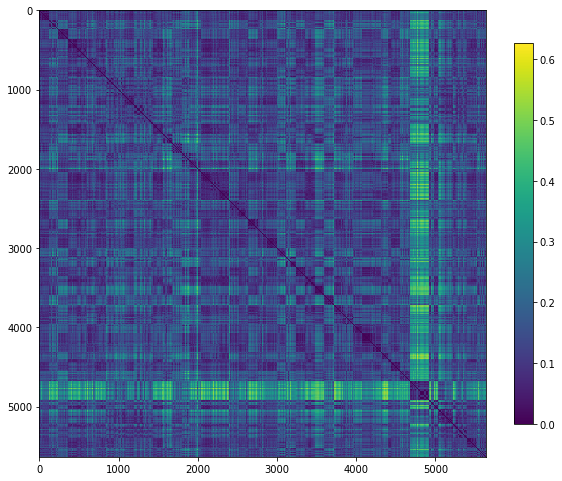

In [37]:
def form_pairs(x):
## this function provides the cosine similarity metric plots a histogram intensity 
    D = spdist.squareform(spdist.pdist(x, metric='cosine'))
    plt.figure(figsize=(10, 10))
    plt.imshow(D, interpolation='nearest')
    plt.colorbar(shrink=0.7)
    close_pairs = D +np.eye(D.shape[0]) < 0.01
    close_ij= np.transpose(np.nonzero(close_pairs))
    incoherent_ij = [(i, j) for i, j in close_ij if dice_coefficent(masks[i], masks[j]) < 0.2]
    incoherent_ij = np.array(incoherent_ij)
    valids = np.ones(len(im))
    return incoherent_ij , valids
incoherent_ij , valids= form_pairs(x)

In [16]:
# print(len(valids))
## this function gets information from the similariy list and removes fro them list of train images
def remove_inchorent(inchorent_ij, valids):
    for i, j in incoherent_ij:
        if np.sum(masks[j])==0 or np.sum(masks[i])==0 :
            valids[i]= 0

    train_img=[]
    train_masks=[]
    for i in np.flatnonzero(valids):
        img = Image.open(imgnames[i])
    #     print(imgnames[i].replace(".tif", "_mask.tif"))
        mk= Image.open(imgnames[i].replace(".tif", "_mask.tif"))
        img_resize = img.resize((128,128))
        mk_resize = mk.resize((128,128))
        train_img.append(np.asarray(img_resize))
        train_masks.append(np.asarray(mk_resize))
    return train_img, train_masks

train_img, train_masks=remove_inchorent(incoherent_ij, valids)

In [12]:
def save(train_img, train_masks):
    np.save('train_images.npy',np.asarray(train_img))
    np.save('train_masks.npy',np.asarray(train_masks))

    mk= Image.open(imgnames[0].replace(".tif", "_mask.tif"))
    np.asarray(mk).shape
save(train_img, train_masks)